In [20]:
!pip -q install kagglehub

import kagglehub
from pathlib import Path
import os

dataset_path = kagglehub.dataset_download("mateuszbuda/lgg-mri-segmentation")

DATA_ROOT = Path(dataset_path)
MRI_DIR = DATA_ROOT / "kaggle_3m"

print("Dataset path:", DATA_ROOT)
print("MRI directory:", MRI_DIR)
print("Total patient folders:", len(os.listdir(MRI_DIR)))

Using Colab cache for faster access to the 'lgg-mri-segmentation' dataset.
Dataset path: /kaggle/input/lgg-mri-segmentation
MRI directory: /kaggle/input/lgg-mri-segmentation/kaggle_3m
Total patient folders: 112


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage import io, color, filters, exposure, morphology
from skimage.metrics import adapted_rand_error

# Set dataset path (same dataset)
DATA_DIR = Path("Brain-tumor")  # keep your original dataset folder name

In [23]:
def collect_image_mask_pairs(data_dir):
    pairs = []

    for patient_folder in sorted(data_dir.iterdir()):
        if patient_folder.is_dir():
            image_files = sorted([
                f for f in patient_folder.glob("*.tif")
                if "_mask" not in f.name
            ])

            for img_path in image_files:
                mask_path = img_path.with_name(img_path.stem + "_mask.tif")

                if mask_path.exists():
                    pairs.append((img_path, mask_path))

    return pairs


def load_mri_sample(img_path, mask_path, size=(256, 256)):
    from skimage import io, color
    from skimage.transform import resize
    import numpy as np

    image = io.imread(img_path)
    mask = io.imread(mask_path)

    if image.ndim == 3:
        image = color.rgb2gray(image)

    image = resize(image, size, anti_aliasing=True)
    mask = resize(mask, size, anti_aliasing=False)

    image = (image - image.min()) / (image.max() - image.min() + 1e-8)

    mask = (mask > 0).astype(np.uint8)

    return image, mask


pairs = collect_image_mask_pairs(MRI_DIR)
print("Total MRI slices found:", len(pairs))

Total MRI slices found: 3929


In [25]:
def preprocess_mri(image):
    # CLAHE improves tumor visibility in MRI
    enhanced = exposure.equalize_adapthist(image, clip_limit=0.02)
    return enhanced

In [26]:
def otsu_segmentation(image):
    thresh = filters.threshold_otsu(image)
    binary = image > thresh
    return postprocess_mask(binary)


def sauvola_segmentation(image, window_size=31, k=0.2):
    local_thresh = filters.threshold_sauvola(image, window_size=window_size, k=k)
    binary = image > local_thresh
    return postprocess_mask(binary)

In [27]:
def postprocess_mask(mask):
    mask = morphology.remove_small_objects(mask, min_size=50)
    mask = morphology.remove_small_holes(mask, area_threshold=50)
    mask = morphology.binary_opening(mask, morphology.disk(2))
    return mask.astype(np.uint8)

In [28]:
def dice_score(gt, pred):
    intersection = np.sum(gt * pred)
    return (2 * intersection) / (np.sum(gt) + np.sum(pred) + 1e-8)


def jaccard_score(gt, pred):
    intersection = np.sum(gt * pred)
    union = np.sum((gt + pred) > 0)
    return intersection / (union + 1e-8)

In [29]:
results = []

# Limit to first 200 images for faster Colab execution (optional)
sample_pairs = pairs[:200]

for img_path, mask_path in tqdm(sample_pairs):
    image, gt_mask = load_mri_sample(img_path, mask_path)

    # Preprocess MRI
    processed_img = preprocess_mri(image)

    # Apply segmentation methods (as per project requirement)
    otsu_mask = otsu_segmentation(processed_img)
    sauvola_mask = sauvola_segmentation(processed_img)

    # Calculate metrics
    dice_otsu = dice_score(gt_mask, otsu_mask)
    jaccard_otsu = jaccard_score(gt_mask, otsu_mask)

    dice_sauvola = dice_score(gt_mask, sauvola_mask)
    jaccard_sauvola = jaccard_score(gt_mask, sauvola_mask)

    results.append({
        "Image": img_path.name,
        "Dice_Otsu": dice_otsu,
        "Jaccard_Otsu": jaccard_otsu,
        "Dice_Sauvola": dice_sauvola,
        "Jaccard_Sauvola": jaccard_sauvola
    })

results_df = pd.DataFrame(results)
results_df.head()

100%|██████████| 200/200 [00:21<00:00,  9.18it/s]


,Image,Dice_Otsu,Jaccard_Otsu,Dice_Sauvola,Jaccard_Sauvola
0,TCGA_CS_4941_19960909_1.tif,0.000000,0.000000,0.000000,0.000000
1,TCGA_CS_4941_19960909_10.tif,0.000000,0.000000,0.000000,0.000000
2,TCGA_CS_4941_19960909_11.tif,0.095523,0.050157,0.064723,0.033444
3,TCGA_CS_4941_19960909_12.tif,0.172405,0.094334,0.123499,0.065813
4,TCGA_CS_4941_19960909_13.tif,0.181282,0.099675,0.121445,0.064648


In [30]:
summary = results_df[[
    "Dice_Otsu", "Jaccard_Otsu",
    "Dice_Sauvola", "Jaccard_Sauvola"
]].agg(["mean", "std"])

print("=== Performance Comparison: Otsu vs Sauvola ===")
print(summary)

=== Performance Comparison: Otsu vs Sauvola ===
      Dice_Otsu  Jaccard_Otsu  Dice_Sauvola  Jaccard_Sauvola
mean   0.051706      0.029362      0.031026         0.016738
std    0.097043      0.057033      0.059305         0.032729


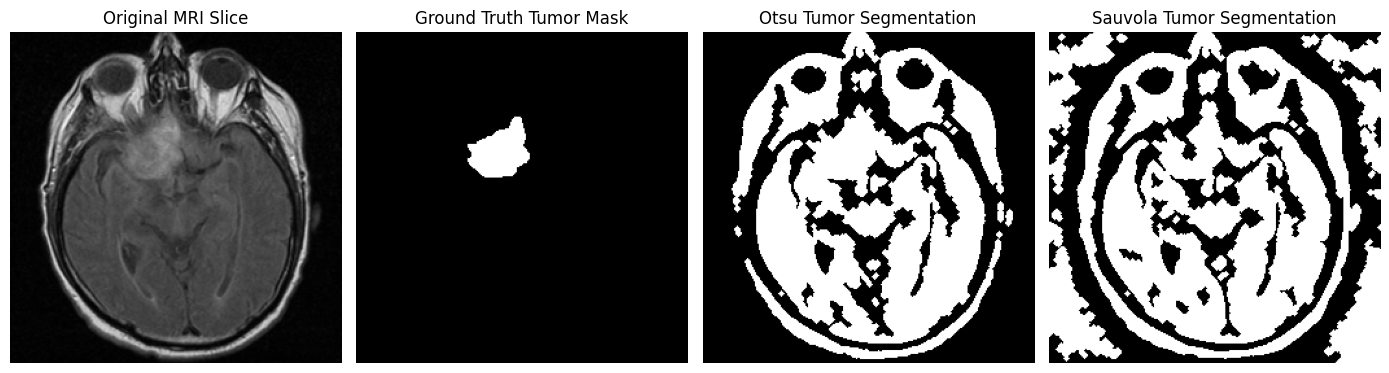

In [32]:
# Select a slice that contains tumor
for i, (img_path, mask_path) in enumerate(pairs):
    image, gt_mask = load_mri_sample(img_path, mask_path)
    if np.sum(gt_mask) > 500:
        break

processed_img = preprocess_mri(image)
otsu_pred = otsu_segmentation(processed_img)
sauvola_pred = sauvola_segmentation(processed_img)

plt.figure(figsize=(14, 4))

plt.subplot(1, 4, 1)
plt.title("Original MRI Slice")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.title("Ground Truth Tumor Mask")
plt.imshow(gt_mask, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.title("Otsu Tumor Segmentation")
plt.imshow(otsu_pred, cmap="gray")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.title("Sauvola Tumor Segmentation")
plt.imshow(sauvola_pred, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()